# Brain-Score Benchmark Tutorial

#### What you will get out of today:
1. How to package your data and your experiment stimulus data (with a focus on behavioral data)
2. How to run a model locally against your experimental stimulus data
3. How to calculate your ceiling
4. How to assemble your benchmark plugin
5. How to score any model against your benchmark

**What are Brain Models?**

Brain Models are ANNs that have undergone the BrainCommitment process. This process is an attempt to map specific layers of the model to specific regions in the brain. 

For simplicity, Brain Models can be thought of as an artificial subject.

<br>

**What is a benchmark?**

Benchmarks define the experiment we want to run on the Brain Model, and how we want to compare the experimental data to the model data (through the metric). 

<br> 

**Brain-Score allows us to run the same sets of experiments that we normally only do on natural subjects, but on artificial subjects (i.e., Brain Models).**

<br>

**What is a metric?** 

Metrics define how we want to compare the experimental data to the model data. 
By choosing a metric, we are making a commitment to what we care about in the two systems we are comparing.

<br>



**What goes into making a benchmark?**

Every benchmark is made up of the following components:
1. The Experimental Data (defines the stimulus and the experimental measures) - DataAssembly
2. The Metric (defines how we want to compare the experimental data to the model)
3. The Ceiling calculation (defines the maximum score for a perfect model)

The Experimental Data has two key components:
1. The Stimulus Set - the stimuli that is presented and associated metadata (zip + csv file)
2. The DataAssembly - the experimental data (netcdf file)

**Requirements for Stimulus Set:**
1. CSV file containing the following columns:
    - stimulus_id
    - image_label (the label for the image)
    - additional metadata (optional but recommended)
    - **NOTE**: The filename column does not need to be included as it will be added back when the stimulus set is packaged.
2. ZIP file containing the stimuli images:
    - filename.png
    - filename.png
    - ...

**Requirements for DataAssembly:**
1. stimulus_id (used to produce the filename)
3. choice
4. subject
5. replication
5. Additional metadata (e.g., truth, block number, trial number, hemisphere, electrode position x, electrode position y, etc.) - more is better

Contained in the data assembly is anything that is relevant to making the comparison you want to make with the model.

# How to package your data (creating the data_packaging.py)

## Package Stimulus Set

In [1]:
from brainio.packaging import package_stimulus_set
from brainio.stimuli import StimulusSet
import pandas as pd
import os
from pathlib import Path

# For Local Development (you can also just use these functions)
from brainio import fetch
from brainio.packaging import (create_stimulus_csv, create_stimulus_zip)

#### Load our raw stimulus data and metadata

In [2]:
img_path = 'data_packaging_contents/imagenet_pseudo/'
metadata_path = 'data_packaging_contents/stimulus_metadata.csv'

# Storage variables
stimuli = []
image_paths = {}

In [5]:
# Read our metadata
metadata_df = pd.read_csv(metadata_path)
metadata_df['stimulus_id'] = metadata_df['stimulus_id'].astype(str)
metadata_df.head(10)

,stimulus_id,filename,category
0,92,stimulus_92.jpg,animate
1,130,stimulus_130.jpg,inanimate
2,17,stimulus_17.jpg,animate
3,176,stimulus_176.jpg,inanimate
4,154,stimulus_154.jpg,inanimate
5,79,stimulus_79.jpg,animate
6,120,stimulus_120.jpg,inanimate
7,88,stimulus_88.jpg,animate
8,22,stimulus_22.jpg,animate
9,171,stimulus_171.jpg,inanimate


#### Creating our StimulusSet object

In [6]:
# Add additional metadata if necessary
metadata_df['stimuli_source'] = ['tiny_imagenet'] * len(metadata_df)
metadata_df['image_label'] = metadata_df['category']

stimuli = StimulusSet(metadata_df)

for _, row in metadata_df.iterrows():
    # Map each stimulus_id to its full path
    image_paths[row['stimulus_id']] = os.path.join(img_path, row['filename'])

# Set the stimulus paths
stimuli.stimulus_paths = image_paths

# Remove the filename column before packaging (package_stimulus_set will add it back)
stimuli = stimuli.drop('filename', axis=1)

# Set name attribute
stimuli.name = 'animate_or_not'

stimuli.head(10)


,stimulus_id,category,stimuli_source,image_label
0,92,animate,tiny_imagenet,animate
1,130,inanimate,tiny_imagenet,inanimate
2,17,animate,tiny_imagenet,animate
3,176,inanimate,tiny_imagenet,inanimate
4,154,inanimate,tiny_imagenet,inanimate
5,79,animate,tiny_imagenet,animate
6,120,inanimate,tiny_imagenet,inanimate
7,88,animate,tiny_imagenet,animate
8,22,animate,tiny_imagenet,animate
9,171,inanimate,tiny_imagenet,inanimate


In [7]:
stimuli.stimulus_paths

{'92': 'data_packaging_contents/imagenet_pseudo/stimulus_92.jpg',
 '130': 'data_packaging_contents/imagenet_pseudo/stimulus_130.jpg',
 '17': 'data_packaging_contents/imagenet_pseudo/stimulus_17.jpg',
 '176': 'data_packaging_contents/imagenet_pseudo/stimulus_176.jpg',
 '154': 'data_packaging_contents/imagenet_pseudo/stimulus_154.jpg',
 '79': 'data_packaging_contents/imagenet_pseudo/stimulus_79.jpg',
 '120': 'data_packaging_contents/imagenet_pseudo/stimulus_120.jpg',
 '88': 'data_packaging_contents/imagenet_pseudo/stimulus_88.jpg',
 '22': 'data_packaging_contents/imagenet_pseudo/stimulus_22.jpg',
 '171': 'data_packaging_contents/imagenet_pseudo/stimulus_171.jpg',
 '9': 'data_packaging_contents/imagenet_pseudo/stimulus_9.jpg',
 '11': 'data_packaging_contents/imagenet_pseudo/stimulus_11.jpg',
 '13': 'data_packaging_contents/imagenet_pseudo/stimulus_13.jpg',
 '134': 'data_packaging_contents/imagenet_pseudo/stimulus_134.jpg',
 '187': 'data_packaging_contents/imagenet_pseudo/stimulus_187.jpg'

#### Note: Make sure you do not put your local filepath into the StimulusSet. When you run the `package_stimulus_set` function, it will add it back with a relative_path that Brain-Score can reliably use

In [8]:
assert len(stimuli) == 200
assert len(stimuli.columns) == 4


### Normally, you would package and upload to S3

In [9]:
# Package and upload to S3
package_stimulus_set('brainio_brainscore', 
                    stimuli, 
                    stimulus_set_identifier='animate_or_not', 
                    bucket_name='brainscore-storage/brainio-brainscore')

upload to s3:   0%|          | 0.00/8.64k [00:00<?, ?B/s]Error retrieving user info: Unable to locate credentials
upload to s3:   0%|          | 0.00/8.64k [00:01<?, ?B/s]


NoCredentialsError: Unable to locate credentials

The above error is fine for local development as the stimulus set was still packaged and saved to your `.brainio` directory. 

Just without credentials, the upload will fail. We are working on an easier way to do this without requiring Brain-Score to hand out credentials.

### For local development, we can create the csv and zip files and store them in the brainio directory

The below code is most of what gets run when you run the `package_stimulus_set` function.

In [ ]:
stimulus_set_identifier = stimuli.name
proto_stimulus_set = stimuli

# Naming
stimulus_store_identifier = "stimulus_" + stimulus_set_identifier.replace(".", "_")

# CSV
csv_file_name = stimulus_store_identifier + ".csv"
target_csv_path = Path(fetch.get_local_data_path()) / stimulus_store_identifier / csv_file_name
# ZIP
zip_file_name = stimulus_store_identifier + ".zip"
target_zip_path = Path(fetch.get_local_data_path()) / stimulus_store_identifier / zip_file_name

# Create csv and zip files and store in brainio folder
stimulus_zip_sha1, zip_filenames = create_stimulus_zip(proto_stimulus_set, str(target_zip_path))
assert 'filename' not in proto_stimulus_set.columns, "StimulusSet already has column 'filename'"
proto_stimulus_set['filename'] = zip_filenames  # keep record of zip (or later local) filenames
csv_sha1 = create_stimulus_csv(proto_stimulus_set, str(target_csv_path))


#### There you have it! You've already packaged your first stimulus set 🎉

Now, if your benchmark will require you to classify non-imagenet labels, you will need to package a second stimulus set that will be used to train a decoder. This can be a small subset of held-out data from your first stimulus set.

## Package DataAssembly

In [11]:
from brainio.packaging import package_data_assembly
from brainio.assemblies import BehavioralAssembly
import pandas as pd


# For Local Development
from brainio import fetch
from brainio.packaging import (create_stimulus_csv, create_stimulus_zip)

#### Load our experimental data and metadata

In [12]:
experimental_data_path = 'data_packaging_contents/experimental_data.csv'
data_df = pd.read_csv(experimental_data_path)

# Map user choice to label (1 = animate, 0 = inanimate)
data_df['choice_label'] = data_df['category-choice'].map({1: 'animate', 0: 'inanimate'})
# Map ground truth to label (1 = animate, 0 = inanimate)
data_df['truth_label'] = data_df['truth'].map({1: 'animate', 0: 'inanimate'})

# Rename category-choice column to choice
data_df.rename(columns={'category-choice': 'choice'}, inplace=True)

data_df.head(20)

,stimulus_id,participant_id,choice,truth,choice_label,truth_label
0,0,1,1,1,animate,animate
1,1,1,1,1,animate,animate
2,2,1,1,1,animate,animate
3,3,1,1,1,animate,animate
4,4,1,1,1,animate,animate
5,5,1,1,1,animate,animate
6,6,1,1,1,animate,animate
7,7,1,1,1,animate,animate
8,8,1,1,1,animate,animate
9,9,1,1,1,animate,animate


#### Create our Behavioral DataAssembly object

Creating a DataAssembly object is slightly different from creating a StimulusSet object.
StimulusSets are build on top of pandas DataFrames, so they operate in 2D (tabular) space.
DataAssemblies are a subclass of xarray, so they can operate in N-dimensional space (including 2D)

<br>

`data_df['choice']` is our **data argument**. It is the primary data that will be stored in the assembly object. In this case, it is a pandas dataframe but can be anything. 

The data argument forms the values of the array within the assembly. 

All other information (like coordinates) are used to label or index this data.

<br>

`coords` is our **coordinate argument**. It is a dictionary that the coordinate names to tuples. The tuple specifies the dimension name (`presentation`) and the cooresponding array-like coordinate values (typically extracted from the data dataframe).

The coordinates add context to the data. They allow us to select, group, or index the data later.

<br>

`dims` is our **dimension argument**. It is just a list of the dimensions of the assembly. It establishes the axes along which the data and the coordinates are arranged.

<br>

`attr` are **attributes** that provide additional metadata that applies globally to the dataset.




In [13]:
assembly = BehavioralAssembly(data_df['choice'],
                              coords={
                                  'stimulus_id' : ('presentation', data_df['stimulus_id']),
                                  'subject' : ('presentation', data_df['participant_id']),
                                  'choice': ('presentation', data_df['choice']),
                                  'truth' : ('presentation', data_df['truth']),
                                  'choice_label' : ('presentation', data_df['choice_label']),
                                  'truth_label' : ('presentation', data_df['truth_label']),
                              },
                              dims=['presentation']
                              )
assembly.attrs['stimulus_set'] = stimuli
assembly.attrs['identifier'] = 'animate_or_not'
assembly.name = 'animate_or_not'

In [14]:
assembly

<xarray.BehavioralAssembly 'animate_or_not' (presentation: 100000)>
array([1, 1, 1, ..., 0, 0, 0])
Coordinates:
  * presentation  (presentation) MultiIndex
  - stimulus_id   (presentation) int64 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
  - subject       (presentation) int64 1 1 1 1 1 1 1 1 ... 10 10 10 10 10 10 10
  - choice        (presentation) int64 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 1 0 0 0 0
  - truth         (presentation) int64 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0
  - choice_label  (presentation) object 'animate' 'animate' ... 'inanimate'
  - truth_label   (presentation) object 'animate' 'animate' ... 'inanimate'
Attributes:
    stimulus_set:      stimulus_id   category stimuli_source image_label file...
    identifier:    animate_or_not

Our data assembly is made up of 100,000 rows of data that contain the above columns.

In [15]:
assert len(assembly) == 100000
assert len(assembly['stimulus_id']) == 100000
assert len(assembly['subject']) == 100000
assert len(assembly['truth']) == 100000
assert len(assembly['choice_label']) == 100000
assert len(assembly['truth_label']) == 100000

### Normally, you would package and upload to S3

In [16]:
package_data_assembly('brainio_brainscore', 
                       assembly, 
                       assembly_identifier='animate_or_not', 
                       stimulus_set_identifier='animate_or_not', 
                       assembly_class_name='BehavioralAssembly', 
                       bucket_name='brainscore-storage/brainio-brainscore')

upload to s3:   0%|          | 0.00/15.2M [00:00<?, ?B/s]Error retrieving user info: Unable to locate credentials
upload to s3:   0%|          | 0.00/15.2M [00:04<?, ?B/s]


NoCredentialsError: Unable to locate credentials

#### Almost there! We now have all our data packaged and ready to use! 🎉

# Test stimuli on a model

The below is used to test if our data and stimuli packaging worked. It will allow us to also use a Jupyter notebook to start building out our benchmark.

In [1]:
from brainio.stimuli import StimulusSetLoader
from brainio.assemblies import AssemblyLoader, BehavioralAssembly
from brainio.fetch import get_local_data_path, resolve_stimulus_set_class
from brainio.fetch import unzip

identifier = 'animate_or_not'

'''
Specify the .brainio path and then use the loader to load the data.
'''

# Stimulus Set Test
local_path = get_local_data_path() + '/stimulus_animate_or_not'
csv_path = local_path + '/stimulus_animate_or_not.csv'
zip_path = local_path + '/stimulus_animate_or_not.zip'
stimuli_directory = unzip(zip_path)
loader = StimulusSetLoader(
        csv_path=csv_path,
        stimuli_directory=stimuli_directory,
        cls=resolve_stimulus_set_class('StimulusSet')
    )
stimulus_set = loader.load()
stimulus_set.identifier = identifier
print(f"Stimulus set loaded: {stimulus_set.identifier}")

# Data Assembly Test
local_path = get_local_data_path() + '/assy_animate_or_not'
nc_path = local_path + '/assy_animate_or_not.nc'
loader = AssemblyLoader(file_path=nc_path,
                        cls=BehavioralAssembly)
data_assembly = loader.load()
data_assembly.attrs['identifier'] = identifier
print(f"Data assembly loaded: {data_assembly.identifier}")

# Stimulus Set Train
local_path = get_local_data_path() + '/stimulus_animate_or_not_train'
csv_path = local_path + '/stimulus_animate_or_not_train.csv'
zip_path = local_path + '/stimulus_animate_or_not_train.zip'
stimuli_directory = unzip(zip_path)
loader = StimulusSetLoader(
        csv_path=csv_path,
        stimuli_directory=stimuli_directory,
        cls=resolve_stimulus_set_class('StimulusSet')
    )
stimulus_set_train = loader.load()
stimulus_set_train.identifier = identifier+"_train"
print(f"Stimulus set loaded: {stimulus_set_train.identifier}")


Stimulus set loaded: animate_or_not
Data assembly loaded: animate_or_not
Stimulus set loaded: animate_or_not_train


**NOTE**: The stimulus set train is not required for all benchmarks. It is only required if you need to train a decoder on a subset of your data (e.g.,for non-imagenet labels). You will be using this StimulusSet to train the model to learn how to perform the task before being tested on new images.

In [2]:
# Standard imports
from brainscore_vision import load_model, load_stimulus_set, load_dataset,load_metric
from brainscore_vision.model_interface import BrainModel
from brainscore_vision.benchmark_helpers.screen import place_on_screen
import numpy as np


/opt/anaconda3/envs/benchmark/lib/python3.11/site-packages/brainscore_core/metrics/__init__.py:16: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):


In [37]:
# Load our model, stimuli, and data assembly
model = load_model('resnet50_tutorial')
_stimuli = stimulus_set
_fitting_stimuli = stimulus_set_train # Only used to train the model
_assembly = data_assembly

/opt/anaconda3/envs/benchmark/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/benchmark/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
assert len(_assembly) == 100000

In [39]:
_assembly

<xarray.BehavioralAssembly 'data' (presentation: 100000)>
dask.array<open_dataset-63ba72be50567180556ed058f227c1b6data, shape=(100000,), dtype=int64, chunksize=(100000,), chunktype=numpy.ndarray>
Coordinates:
  * presentation  (presentation) MultiIndex
  - stimulus_id   (presentation) int64 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
  - subject       (presentation) int64 1 1 1 1 1 1 1 1 ... 10 10 10 10 10 10 10
  - choice        (presentation) int64 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 1 0 0 0 0
  - truth         (presentation) int64 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0
  - choice_label  (presentation) object 'animate' 'animate' ... 'inanimate'
  - truth_label   (presentation) object 'animate' 'animate' ... 'inanimate'
Attributes:
    identifier:               animate_or_not
    stimulus_set_identifier:  animate_or_not

`image_label` is a Brain-Score standard column name that contains the ground truth labels for the stimuli. Ideally, you add this in the beginning but I forgot to do so...so we do it now.

In [40]:
# add truth labels (ie image_labels) to stimuli and training data
_stimuli["image_label"] = _stimuli["category"]
_fitting_stimuli["image_label"] = _fitting_stimuli["category"]

In [41]:
print(_fitting_stimuli.head(10))
print("\n", _stimuli.head(10))

  filename image_label stimuli_source   category  stimulus_id
0  178.jpg   inanimate  tiny_imagenet  inanimate          178
1  106.jpg   inanimate  tiny_imagenet  inanimate          106
2    7.jpg     animate  tiny_imagenet    animate            7
3   79.jpg     animate  tiny_imagenet    animate           79
4  161.jpg   inanimate  tiny_imagenet  inanimate          161
5  141.jpg   inanimate  tiny_imagenet  inanimate          141
6   75.jpg     animate  tiny_imagenet    animate           75
7   14.jpg     animate  tiny_imagenet    animate           14
8  195.jpg   inanimate  tiny_imagenet  inanimate          195
9   61.jpg     animate  tiny_imagenet    animate           61

    stimulus_id filename image_label   category stimuli_source
0           92   92.jpg     animate    animate  tiny_imagenet
1          130  130.jpg   inanimate  inanimate  tiny_imagenet
2           17   17.jpg     animate    animate  tiny_imagenet
3          176  176.jpg   inanimate  inanimate  tiny_imagenet
4     

`place_on_screen` is a function that takes the images and resizes them to match how they would appear to a viewer at a specific visual angle

In [53]:
fitting_stimuli_on_screen = place_on_screen(_fitting_stimuli,
                                  target_visual_degrees=model.visual_degrees(),
                                  source_visual_degrees=4)

convert image degrees: 100%|██████████| 200/200 [00:00<00:00, 3733.43it/s]
/Users/kartik/benchmark_tutorial/vision/brainscore_vision/benchmark_helpers/screen.py:72: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  converted_stimuli.original_paths = copy.deepcopy(stimulus_set.stimulus_paths)


In [54]:
fitting_stimuli_on_screen["image_label"] = fitting_stimuli_on_screen["category"]

In [55]:
fitting_stimuli_on_screen.head(10)

,filename,image_label,stimuli_source,category,stimulus_id,degrees
0,178.jpg,inanimate,tiny_imagenet,inanimate,178,8
1,106.jpg,inanimate,tiny_imagenet,inanimate,106,8
2,7.jpg,animate,tiny_imagenet,animate,7,8
3,79.jpg,animate,tiny_imagenet,animate,79,8
4,161.jpg,inanimate,tiny_imagenet,inanimate,161,8
5,141.jpg,inanimate,tiny_imagenet,inanimate,141,8
6,75.jpg,animate,tiny_imagenet,animate,75,8
7,14.jpg,animate,tiny_imagenet,animate,14,8
8,195.jpg,inanimate,tiny_imagenet,inanimate,195,8
9,61.jpg,animate,tiny_imagenet,animate,61,8


`start_task` initializes the model for the task (in this case, using the training set), extracts features from the models, and trains a classifier on these features.

Refer to the `vision/brainscore_vision/model_helpers/brain_transformation/behavior.py` file for more details on how the behavioral tasks are implemented.


In [56]:
model.start_task(BrainModel.Task.probabilities, fitting_stimuli=fitting_stimuli_on_screen, number_of_trials=1)

activations:   0%|          | 0/256 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/benchmark/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


We now use `place_on_screen` to resize the testing set

In [57]:
stimulus_on_screen = place_on_screen(_stimuli, 
                                     target_visual_degrees=model.visual_degrees(), 
                                     source_visual_degrees=4)

convert image degrees: 100%|██████████| 200/200 [00:00<00:00, 4318.50it/s]
/Users/kartik/benchmark_tutorial/vision/brainscore_vision/benchmark_helpers/screen.py:72: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  converted_stimuli.original_paths = copy.deepcopy(stimulus_set.stimulus_paths)


`look_at` takes the new test stimuli, gets model features for these stimuli, uses the trained behavior classifier to make predictions, and returns the probabilities for each class.

In [58]:
model_response = model.look_at(stimulus_on_screen, number_of_trials=1)
model_response

activations:   0%|          | 0/256 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.BehavioralAssembly (presentation: 200, choice: 2)>
array([[0.02552222, 0.9744778 ],
       [0.6229116 , 0.37708843],
       [0.05717677, 0.9428233 ],
       [0.5493726 , 0.45062736],
       [0.8886216 , 0.11137838],
       [0.12319284, 0.87680715],
       [0.8655766 , 0.13442336],
       [0.11890551, 0.88109446],
       [0.344468  , 0.655532  ],
       [0.78111464, 0.21888536],
       [0.6471737 , 0.3528263 ],
       [0.02245581, 0.9775442 ],
       [0.1184722 , 0.8815278 ],
       [0.5006297 , 0.49937025],
       [0.75566345, 0.24433649],
       [0.88902915, 0.1109708 ],
       [0.4126425 , 0.5873575 ],
       [0.2844351 , 0.71556497],
       [0.5669442 , 0.43305588],
       [0.7710708 , 0.2289292 ],
...
       [0.05623742, 0.94376254],
       [0.5657492 , 0.43425077],
       [0.73376703, 0.266233  ],
       [0.82807547, 0.17192455],
       [0.09882566, 0.9011743 ],
       [0.79491585, 0.20508412],
       [0.03918177, 0.96081823],
       [0.6745704 , 0.32542956],
       [0.11980198, 0.88019806],
       [0.28633636, 0.71366364],
       [0.09173314, 0.90826684],
       [0.9064482 , 0.09355181],
       [0.9424035 , 0.05759643],
       [0.830296  , 0.169704  ],
       [0.14638668, 0.85361326],
       [0.9778112 , 0.02218882],
       [0.08309741, 0.9169026 ],
       [0.76701653, 0.23298351],
       [0.5723948 , 0.4276052 ],
       [0.903319  , 0.09668097]], dtype=float32)
Coordinates:
  * choice                        (choice) <U9 'inanimate' 'animate'
  * presentation                  (presentation) MultiIndex
  - filename                      (presentation) object '92.jpg' ... '137.jpg'
  - image_label                   (presentation) object 'animate' ... 'inanim...
  - microsaccade_shift_x_degrees  (presentation) float64 0.0 0.0 0.0 ... 0.0 0.0
  - stimuli_source                (presentation) object 'tiny_imagenet' ... '...
  - microsaccade_shift_x_pixels   (presentation) float64 0.0 0.0 0.0 ... 0.0 0.0
  - degrees                       (presentation) int64 8 8 8 8 8 8 ... 8 8 8 8 8
  - stimulus_id                   (presentation) int64 92 130 17 ... 142 107 137
  - microsaccade_shift_y_degrees  (presentation) float64 0.0 0.0 0.0 ... 0.0 0.0
  - microsaccade_shift_y_pixels   (presentation) float64 0.0 0.0 0.0 ... 0.0 0.0
  - category                      (presentation) object 'animate' ... 'inanim...

The data assembly that is returned looks very similar to the data assembly that we previously created 👀

We need to convert the class probabilities to a class label. This is easy for a binary classification task like this one.

In [59]:
def convert_probabilities_to_choices(source: BehavioralAssembly) -> np.array:
    """
    Convert probabilities to choices.
    """
    decisions = np.argmax(source.values, axis=1)
    choices = [source['choice'].values[decision] for decision in decisions]
    return BehavioralAssembly(choices, coords={'presentation': source['presentation']})

In [60]:
model_response = convert_probabilities_to_choices(model_response)
model_response

<xarray.BehavioralAssembly (presentation: 200)>
array(['animate', 'inanimate', 'animate', 'inanimate', 'inanimate',
       'animate', 'inanimate', 'animate', 'animate', 'inanimate',
       'inanimate', 'animate', 'animate', 'inanimate', 'inanimate',
       'inanimate', 'animate', 'animate', 'inanimate', 'inanimate',
       'inanimate', 'animate', 'animate', 'animate', 'inanimate',
       'inanimate', 'animate', 'inanimate', 'inanimate', 'inanimate',
       'animate', 'inanimate', 'inanimate', 'inanimate', 'animate',
       'inanimate', 'inanimate', 'animate', 'inanimate', 'inanimate',
       'animate', 'inanimate', 'animate', 'inanimate', 'animate',
       'animate', 'animate', 'inanimate', 'animate', 'animate', 'animate',
       'inanimate', 'inanimate', 'animate', 'inanimate', 'animate',
       'inanimate', 'animate', 'inanimate', 'animate', 'animate',
       'animate', 'inanimate', 'inanimate', 'inanimate', 'animate',
       'inanimate', 'inanimate', 'inanimate', 'inanimate', 'inanimate',
       'inanimate', 'inanimate', 'animate', 'inanimate', 'animate',
       'inanimate', 'inanimate', 'animate', 'animate', 'animate',
       'animate', 'inanimate', 'animate', 'inanimate', 'animate',
       'inanimate', 'inanimate', 'animate', 'inanimate', 'animate',
       'inanimate', 'animate', 'animate', 'animate', 'animate',
       'inanimate', 'animate', 'animate', 'inanimate', 'inanimate',
       'inanimate', 'animate', 'inanimate', 'inanimate', 'animate',
       'inanimate', 'animate', 'inanimate', 'animate', 'inanimate',
       'animate', 'inanimate', 'inanimate', 'animate', 'animate',
       'inanimate', 'inanimate', 'inanimate', 'animate', 'inanimate',
       'inanimate', 'animate', 'animate', 'animate', 'inanimate',
       'inanimate', 'animate', 'animate', 'inanimate', 'inanimate',
       'animate', 'inanimate', 'inanimate', 'inanimate', 'inanimate',
       'inanimate', 'inanimate', 'animate', 'inanimate', 'animate',
       'animate', 'inanimate', 'inanimate', 'animate', 'animate',
       'animate', 'animate', 'inanimate', 'animate', 'inanimate',
       'animate', 'animate', 'animate', 'animate', 'inanimate', 'animate',
       'inanimate', 'animate', 'animate', 'animate', 'animate',
       'inanimate', 'animate', 'animate', 'animate', 'inanimate',
       'inanimate', 'animate', 'inanimate', 'animate', 'animate',
       'animate', 'animate', 'animate', 'animate', 'animate', 'animate',
       'animate', 'animate', 'animate', 'inanimate', 'inanimate',
       'inanimate', 'animate', 'inanimate', 'animate', 'inanimate',
       'animate', 'animate', 'animate', 'inanimate', 'inanimate',
       'inanimate', 'animate', 'inanimate', 'animate', 'inanimate',
       'inanimate', 'inanimate'], dtype='<U9')
Coordinates:
  * presentation                  (presentation) MultiIndex
  - filename                      (presentation) object '92.jpg' ... '137.jpg'
  - image_label                   (presentation) object 'animate' ... 'inanim...
  - microsaccade_shift_x_degrees  (presentation) float64 0.0 0.0 0.0 ... 0.0 0.0
  - stimuli_source                (presentation) object 'tiny_imagenet' ... '...
  - microsaccade_shift_x_pixels   (presentation) float64 0.0 0.0 0.0 ... 0.0 0.0
  - degrees                       (presentation) int64 8 8 8 8 8 8 ... 8 8 8 8 8
  - stimulus_id                   (presentation) int64 92 130 17 ... 142 107 137
  - microsaccade_shift_y_degrees  (presentation) float64 0.0 0.0 0.0 ... 0.0 0.0
  - microsaccade_shift_y_pixels   (presentation) float64 0.0 0.0 0.0 ... 0.0 0.0
  - category                      (presentation) object 'animate' ... 'inanim...

#### Now that we have our model's behavior, we can calculate the raw score.

I'm using accuracy for simplicity for this tutorial, but it is not a great metric in most cases. If Brain-Score does not have a metric that is suitable for you, you can create your own by building a custom metrics plugins.

In [61]:
metric = load_metric('accuracy')
raw_score = metric(model_response.values, _stimuli['image_label'].values)
raw_score

<xarray.Score ()>
array(0.96)
Attributes:
    error:    0.19595917942265428
    raw:      [ True  True  True  True  True  True  True  True  True  True Fa...

Because our task is an easy one, our model performed quite well!

#### Now we need to  calculate our ceiling. This typically represents the maximum score a perfect model can achieve, and might not always be 1. It is largely based on what your metric was comparing.

**Although you can choose any ceiling, we strongly encourage you to use the exact same metric you used to compare the models with subject data.**

In our case, we had 10 subjects perform this task. One way we can calculate the average model performance is by calculating the average accuracy across all subjects (NOTE: This only works if there is very little variance in the subject accuracies).

In [62]:
from brainscore_core import Metric
from brainscore_vision.metrics import Score
from tqdm import tqdm

def calculate_noise_ceiling(assembly: BehavioralAssembly, metric: Metric) -> Score:
    """
    Calculate noise ceiling by averaging individual subject accuracies.
    
    Args:
        assembly: BehavioralAssembly containing subject responses and ground truth
        metric: Metric to calculate accuracy
    
    Returns:
        Score object containing mean accuracy across subjects and metadata
    """
    # Get unique subjects
    subject_ids = np.unique(assembly.subject.values)
    subject_scores = []
    
    for subject_id in tqdm(subject_ids, desc="Calculating subject accuracies"):
        # Get this subject's data
        subject_mask = assembly.subject.values == subject_id
        subject_data = assembly.isel(presentation=subject_mask)
        
        # Calculate accuracy for this subject
        score = metric(
            subject_data['choice'].values,
            subject_data['truth'].values
        )
        subject_scores.append(score)
    
    # Calculate ceiling statistics
    ceiling = Score(np.mean(subject_scores))
    ceiling.attrs['error'] = np.std(subject_scores)
    ceiling.attrs[Score.RAW_VALUES_KEY] = subject_scores
    ceiling.attrs['n_subjects'] = len(subject_ids)
    ceiling.attrs['individual_scores'] = subject_scores
    
    return ceiling

In [63]:
ceiling = calculate_noise_ceiling(assembly=_assembly, metric=metric)
print(ceiling)


Calculating subject accuracies: 100%|██████████| 10/10 [00:00<00:00, 209.64it/s]

<xarray.Score ()>
array(0.82917)
Attributes:
    error:              0.004252775564263895
    raw:                [<xarray.Score ()>\narray(0.8257)\nAttributes:\n    e...
    n_subjects:         10
    individual_scores:  [<xarray.Score ()>\narray(0.8257)\nAttributes:\n    e...


Our noise ceiling is 0.82895. This is the maximum score a perfect model could achieve on this benchmark.

In [ ]:
import seaborn as sns

individual_scores = ceiling.attrs['individual_scores']
individual_score = [n.values for n in individual_scores]
individual_score = np.array(individual_score)
# Make a histogram of individual scores between 0 and 1
sns.histplot(individual_score, bins=100, binrange=(0, 1))


In [64]:
score = raw_score / ceiling

# In case the model beats human performance, we can cap the score at 1.
if score.values > 1:
    score = Score(np.array(1.))
score.attrs['raw'] = raw_score
score.attrs['ceiling'] = ceiling
score


<xarray.Score ()>
array(1.)
Attributes:
    raw:      <xarray.Score ()>\narray(0.96)\nAttributes:\n    error:    0.19...
    ceiling:  <xarray.Score ()>\narray(0.82917)\nAttributes:\n    error:     ...

Our resnet50_tutorial model scored 0.96 on this benchmark (raw).

Our ceiling for human performance is 0.82895. 

Therefore, our model's Brain-Score is capped at 1.

# Packaging everything together for benchmark submission

## Creating your data plugin


#### \_\_init\_\_.py

In [77]:
from brainio.assemblies import BehavioralAssembly
from brainscore_vision import data_registry, stimulus_set_registry, load_stimulus_set
from brainscore_vision.data_helpers.s3 import load_assembly_from_s3, load_stimulus_set_from_s3

BIBTEX = """TBD"""

stimulus_set_registry['animate_or_not'] = lambda: load_stimulus_set_from_s3(
    identifier='animate_or_not',
    bucket="brainscore-storage/brainio-brainscore",
    csv_sha1="d214e5e5541c99c01ebf8b0bdbed23ca77c64d1f",
    zip_sha1="3660c97fc445836565d3c369a8f0709e9ebf8179",
    csv_version_id="null",
    zip_version_id="null")

data_registry['animate_or_not'] = lambda: load_assembly_from_s3(
    identifier='animate_or_not',
    version_id="null",
    sha1="5564fe7cb9d26be89bed5aedc50b67473e17e08b",
    bucket="brainscore-storage/brainio-brainscore",
    cls=BehavioralAssembly,
    stimulus_set_loader=lambda: load_stimulus_set('animate_or_not'),
)

stimulus_set_registry['animate_or_not_train'] = lambda: load_stimulus_set_from_s3(
    identifier='animate_or_not_train',
    bucket="brainscore-storage/brainio-brainscore",
    csv_sha1="242cecf3b9ed325233d2b7f4f6ec1b18cc15e9e5",
    zip_sha1="80ad50437ba4a6a1514cdf4b791b33d63ba4ddd2",
    csv_version_id="null",
    zip_version_id="null")

## Creating your benchmark plugin

The benchmark plugin is where you define what dataset you want to use to test the model and how you want to make the comparison. Here, you also provide how the ceiling for your benchmark is calculated.

We're going to take everything we've done so far and package it into a subclass of `BenchmarkBase`.

#### \_\_init\_\_.py

In [66]:
from brainscore_vision import benchmark_registry
from brainscore_vision.benchmarks.animate_or_not.benchmark import AnimateOrNot

benchmark_registry['AnimateOrNot'] = lambda: AnimateOrNot()

#### benchmark.py

In [78]:
import numpy as np
from brainscore_core import Metric
from tqdm import tqdm
from brainscore_vision import load_dataset, load_stimulus_set, load_metric
from brainio.assemblies import BehavioralAssembly
from brainscore_vision.benchmark_helpers.screen import place_on_screen
from brainscore_vision.benchmarks import BenchmarkBase
from brainscore_vision.metrics import Score
from brainscore_vision.model_interface import BrainModel

'''
All benchmarks inherit BenchmarkBase, a super-class that requests commonly used attributes.
These attributes include:
- identifier
- version
- ceiling_func
- bibtex
'''

BIBTEX = """demo"""

class AnimateOrNot(BenchmarkBase):
    def __init__(self):
        self._metric = load_metric('accuracy')
        self._assembly = load_dataset('animate_or_not')
        self._stimuli = load_stimulus_set('animate_or_not')
        self._fitting_stimuli = load_stimulus_set('animate_or_not_train')
        self._visual_degrees = 4
        self._number_of_trials = 50
        super(AnimateOrNot, self).__init__(
            identifier='animate_or_not', 
            version=1, 
            ceiling_func=self._get_ceiling,
            parent='behavior', 
            bibtex=BIBTEX)

    def _get_ceiling(self):
        """Get the ceiling score."""
        return calculate_ceiling(self._assembly, self._metric)

    def __call__(self, candidate: BrainModel) -> Score:
        print("Starting AnimateOrNot benchmark")
        # add truth labels (ie image_labels) to stimuli and training data
        self._stimuli["image_label"] = self._stimuli["category"]
        self._fitting_stimuli["image_label"] = self._fitting_stimuli["category"]

        # fit logistic binary decoder and perform task:
        fitting_stimuli_on_screen = place_on_screen(self._fitting_stimuli, target_visual_degrees=candidate.visual_degrees(),
                                           source_visual_degrees=self._visual_degrees)
        candidate.start_task(BrainModel.Task.probabilities, fitting_stimuli_on_screen)
        stimulus_set_on_screen = place_on_screen(self._assembly.stimulus_set, target_visual_degrees=candidate.visual_degrees(),
                                       source_visual_degrees=self._visual_degrees)
        model_response = candidate.look_at(stimulus_set_on_screen, number_of_trials=self._number_of_trials)
        model_response = convert_probabilities_to_choices(model_response)
        raw_score = self._metric(model_response.values, self._stimuli['image_label'].values)
        ceiling = self.ceiling
        score = raw_score / ceiling
        if score.values > 1:
            score = Score(np.array(1.))
        score.attrs['raw'] = raw_score
        score.attrs['ceiling'] = ceiling

        print(score)

        return score

def convert_probabilities_to_choices(source: BehavioralAssembly) -> np.array:
    """
    Convert probabilities to choices.
    """
    decisions = np.argmax(source.values, axis=1)
    choices = [source['choice'].values[decision] for decision in decisions]
    return BehavioralAssembly(choices, coords={'presentation': source['presentation']})

def calculate_ceiling(assembly: BehavioralAssembly, metric: Metric) -> Score:
    """
    Calculate noise ceiling by averaging individual subject accuracies.
    
    Args:
        assembly: BehavioralAssembly containing subject responses and ground truth
        metric: Metric to calculate accuracy
    
    Returns:
        Score object containing mean accuracy across subjects and metadata
    """
    # Get unique subjects
    subject_ids = np.unique(assembly.subject.values)
    subject_scores = []
    
    for subject_id in tqdm(subject_ids, desc="Calculating subject accuracies"):
        # Get this subject's data
        subject_mask = assembly.subject.values == subject_id
        subject_data = assembly.isel(presentation=subject_mask)
        
        # Calculate accuracy for this subject
        score = metric(
            subject_data['choice'].values,
            subject_data['truth'].values
        )
        subject_scores.append(score)
    
    # Calculate ceiling statistics
    ceiling = Score(np.mean(subject_scores))
    ceiling.attrs['error'] = np.std(subject_scores)
    ceiling.attrs[Score.RAW_VALUES_KEY] = subject_scores
    ceiling.attrs['n_subjects'] = len(subject_ids)
    ceiling.attrs['individual_scores'] = subject_scores
    
    return ceiling



#### The \_\_init\_\_.py in both the data and benchmark folders, and the benchmark.py file are the main parts. 

You will also want to add a `requirements.txt` file to each plugin folder if they have additional dependencies. 

It is also best practice to add a `tests.py` file to each plugin folder to test that the plugin is working as expected.


# Testing your benchmark plugin

We should get the exact same score as before.

In [79]:
from brainscore_vision import score
model_score = score(model_identifier="resnet50_tutorial", benchmark_identifier='AnimateOrNot')

/opt/anaconda3/envs/benchmark/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/benchmark/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/anaconda3/envs/benchmark/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value 

Starting AnimateOrNot benchmark


Calculating subject accuracies: 100%|██████████| 10/10 [00:00<00:00, 139.63it/s]

<xarray.Score ()>
array(1.)
Attributes:
    raw:      <xarray.Score ()>\narray(0.96)\nAttributes:\n    error:    0.19...
    ceiling:  <xarray.Score ()>\narray(0.82917)\nAttributes:\n    error:     ...


In [80]:
model_score

<xarray.Score ()>
array(1.)
Attributes:
    raw:                   <xarray.Score ()>\narray(0.96)\nAttributes:\n    e...
    ceiling:               <xarray.Score ()>\narray(0.82917)\nAttributes:\n  ...
    model_identifier:      resnet50_tutorial
    benchmark_identifier:  AnimateOrNot
    comment:               layers: {}

What if we used an untrained alexnet? It should get chance performance.

In [81]:
model_score = score(model_identifier="alexnet", benchmark_identifier='AnimateOrNot')

/opt/anaconda3/envs/benchmark/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/benchmark/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting AnimateOrNot benchmark


activations:   0%|          | 0/256 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/benchmark/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


activations:   0%|          | 0/256 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Score ()>
array(0.57286202)
Attributes:
    raw:      <xarray.Score ()>\narray(0.475)\nAttributes:\n    error:    0.4...
    ceiling:  <xarray.Score ()>\narray(0.82917)\nAttributes:\n    error:     ...


In [82]:
model_score

<xarray.Score ()>
array(0.57286202)
Attributes:
    raw:                   <xarray.Score ()>\narray(0.475)\nAttributes:\n    ...
    ceiling:               <xarray.Score ()>\narray(0.82917)\nAttributes:\n  ...
    model_identifier:      alexnet
    benchmark_identifier:  AnimateOrNot
    comment:               layers: {}

# FINALLY!!! 🥳🍾🍾🍾🍾

# Neural Data Packaging

For the most part, packaging neural data is the same process as behavioral data.

### Creating some pseudo-neural data

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
from brainio.assemblies import DataAssembly, NeuroidAssembly
from brainscore_vision import load_dataset, load_stimulus_set

# Load the behavioral data to match presentations
behavioral_data = load_dataset('animate_or_not')
behavioral_stimuli = load_stimulus_set('animate_or_not')

# Generate random firing rates between -5 and 5
n_neurons = 256
n_stimuli = behavioral_stimuli.stimulus_id.nunique()  # Number of unique stimuli
n_repeats = 50   # Number of repetitions per stimulus
n_presentations = n_stimuli * n_repeats  # Total presentations
n_time_bins = 1

data = np.random.uniform(-5, 5, size=(n_neurons, n_stimuli, n_repeats, n_time_bins))
data.shape

In [ ]:

data = data.reshape(n_neurons, n_presentations, n_time_bins)
data.shape

#### Package the neural data into a NeuroidAssembly

In [48]:
# Neuroid metadata
neuroid_id = [f'MUA_{i}' for i in range(n_neurons)]
col = np.random.randint(0, 10, n_neurons)
row = np.random.randint(5, 10, n_neurons)
y = np.random.uniform(0, 2, n_neurons)
x = np.random.uniform(-2, 2, n_neurons)
hemisphere = ['L'] * n_neurons
subject = ['Kartik'] * n_neurons
region = ['IT'] * n_neurons

# Presentation metadata
stimulus_order = range(n_stimuli)
image_ids = np.repeat(stimulus_set.stimulus_id.values[stimulus_order], n_repeats)
repetitions = np.tile(range(n_repeats), n_stimuli)
stimuli = np.repeat(stimulus_order, n_repeats)
stimulus_ids = np.repeat(stimulus_set.stimulus_id.values[stimulus_order], n_repeats)
category_names = np.repeat(stimulus_set.category.values[stimulus_order], n_repeats)

# Time-bin metadata
time_bin_start = [70]
time_bin_end = [170]

neural_assembly = NeuroidAssembly(
    data, dims=['neuroid', 'presentation', 'time_bin'],
    coords={
        'neuroid_id': ('neuroid', neuroid_id),
        'col': ('neuroid', col),
        'row': ('neuroid', row),
        'y': ('neuroid', y),
        'x': ('neuroid', x),
        'hemisphere': ('neuroid', hemisphere),
        'subject': ('neuroid', subject),
        'region': ('neuroid', region),
        'stimulus_id': ('presentation', stimulus_ids),
        'stimulus': ('presentation', stimuli),
        'repetition': ('presentation', repetitions),
        'category_name': ('presentation', category_names),
        'time_bin_start': ('time_bin', time_bin_start),
        'time_bin_end': ('time_bin', time_bin_end)
    }
)

neural_assembly.name = 'animate_or_not_it'
neural_assembly.attrs['stimulus_set'] = stimulus_set


In [ ]:
from brainio.packaging import package_data_assembly

package_data_assembly('brainio_brainscore', 
                       neural_assembly, 
                       assembly_identifier='animate_or_not_it', 
                       stimulus_set_identifier='animate_or_not_it', 
                       assembly_class_name='NeuroidAssembly', 
                       bucket_name='brainscore-storage/brainio-brainscore')

### Load the neural data and play around with it

In [83]:
from brainio.stimuli import StimulusSetLoader
from brainio.assemblies import AssemblyLoader, BehavioralAssembly
from brainio.fetch import get_local_data_path, resolve_stimulus_set_class
from brainio.fetch import unzip

identifier = 'animate_or_not_it'

# Stimulus Set Test
local_path = get_local_data_path() + '/stimulus_animate_or_not'
csv_path = local_path + '/stimulus_animate_or_not.csv'
zip_path = local_path + '/stimulus_animate_or_not.zip'
stimuli_directory = unzip(zip_path)
loader = StimulusSetLoader(
        csv_path=csv_path,
        stimuli_directory=stimuli_directory,
        cls=resolve_stimulus_set_class('StimulusSet')
    )
stimulus_set = loader.load()
stimulus_set.identifier = identifier

# Data Assembly Test
local_path = get_local_data_path() + '/assy_animate_or_not_it'
nc_path = local_path + '/assy_animate_or_not_it.nc'
loader = AssemblyLoader(file_path=nc_path,
                        cls=BehavioralAssembly)
neural_assembly = loader.load()
neural_assembly.attrs['identifier'] = identifier


In [84]:
neural_assembly

<xarray.BehavioralAssembly 'data' (neuroid: 256, presentation: 10000,
                                   time_bin: 1)>
dask.array<open_dataset-bfe77fd0b47827128560881113523eb7data, shape=(256, 10000, 1), dtype=float64, chunksize=(256, 10000, 1), chunktype=numpy.ndarray>
Coordinates:
  * neuroid         (neuroid) MultiIndex
  - neuroid_id      (neuroid) object 'MUA_0' 'MUA_1' ... 'MUA_254' 'MUA_255'
  - col             (neuroid) int64 5 8 0 0 1 8 9 9 8 7 ... 9 1 7 5 6 4 6 5 1 2
  - row             (neuroid) int64 6 8 5 6 6 5 5 7 5 8 ... 6 8 8 6 6 9 9 8 8 6
  - y               (neuroid) float64 1.475 1.539 1.525 ... 0.6246 0.3719 0.5391
  - x               (neuroid) float64 -1.571 -1.073 -1.194 ... 0.1979 -0.2535
  - hemisphere      (neuroid) object 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L' 'L'
  - subject         (neuroid) object 'Kartik' 'Kartik' ... 'Kartik' 'Kartik'
  - region          (neuroid) object 'IT' 'IT' 'IT' 'IT' ... 'IT' 'IT' 'IT' 'IT'
  * presentation    (presentation) MultiIndex
  - stimulus_id     (presentation) int64 21 21 21 21 21 ... 164 164 164 164 164
  - stimulus        (presentation) int64 0 0 0 0 0 0 ... 199 199 199 199 199 199
  - repetition      (presentation) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
  - category_name   (presentation) object 'animate' 'animate' ... 'inanimate'
  * time_bin        (time_bin) MultiIndex
  - time_bin_start  (time_bin) int64 70
  - time_bin_end    (time_bin) int64 170
Attributes:
    stimulus_set_identifier:  animate_or_not_it
    identifier:               animate_or_not_it

#### Average over repetitions to get average neural response to stimuli


In [85]:
from brainscore_vision.benchmark_helpers.neural_common import average_repetition

neural_data = neural_assembly
benchmark_data = average_repetition(neural_data)
benchmark_data = benchmark_data.squeeze('time_bin')
benchmark_data

<xarray.BehavioralAssembly 'data' (neuroid: 256, presentation: 200)>
dask.array<getitem, shape=(256, 200), dtype=float64, chunksize=(256, 1), chunktype=numpy.ndarray>
Coordinates:
  * neuroid        (neuroid) MultiIndex
  - neuroid_id     (neuroid) object 'MUA_0' 'MUA_1' ... 'MUA_254' 'MUA_255'
  - col            (neuroid) int64 5 8 0 0 1 8 9 9 8 7 2 ... 9 1 7 5 6 4 6 5 1 2
  - row            (neuroid) int64 6 8 5 6 6 5 5 7 5 8 7 ... 6 8 8 6 6 9 9 8 8 6
  - y              (neuroid) float64 1.475 1.539 1.525 ... 0.6246 0.3719 0.5391
  - x              (neuroid) float64 -1.571 -1.073 -1.194 ... 0.1979 -0.2535
  - hemisphere     (neuroid) object 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L' 'L'
  - subject        (neuroid) object 'Kartik' 'Kartik' ... 'Kartik' 'Kartik'
  - region         (neuroid) object 'IT' 'IT' 'IT' 'IT' ... 'IT' 'IT' 'IT' 'IT'
    time_bin       object (70, 170)
  * presentation   (presentation) MultiIndex
  - stimulus_id    (presentation) int64 0 1 2 3 4 5 ... 194 195 196 197 198 199
  - stimulus       (presentation) int64 34 58 86 3 65 70 ... 154 33 173 63 197
  - category_name  (presentation) object 'animate' 'animate' ... 'inanimate'
Attributes:
    stimulus_set_identifier:  animate_or_not_it
    identifier:               animate_or_not_it

#### Plotting neural data with respect to stimuli

/Users/kartik/.brainio/stimulus_animate_or_not/93.jpg
/Users/kartik/.brainio/stimulus_animate_or_not/4.jpg
/Users/kartik/.brainio/stimulus_animate_or_not/33.jpg
/Users/kartik/.brainio/stimulus_animate_or_not/137.jpg
/Users/kartik/.brainio/stimulus_animate_or_not/43.jpg
/Users/kartik/.brainio/stimulus_animate_or_not/89.jpg
/Users/kartik/.brainio/stimulus_animate_or_not/183.jpg
/Users/kartik/.brainio/stimulus_animate_or_not/7.jpg
/Users/kartik/.brainio/stimulus_animate_or_not/64.jpg
/Users/kartik/.brainio/stimulus_animate_or_not/126.jpg


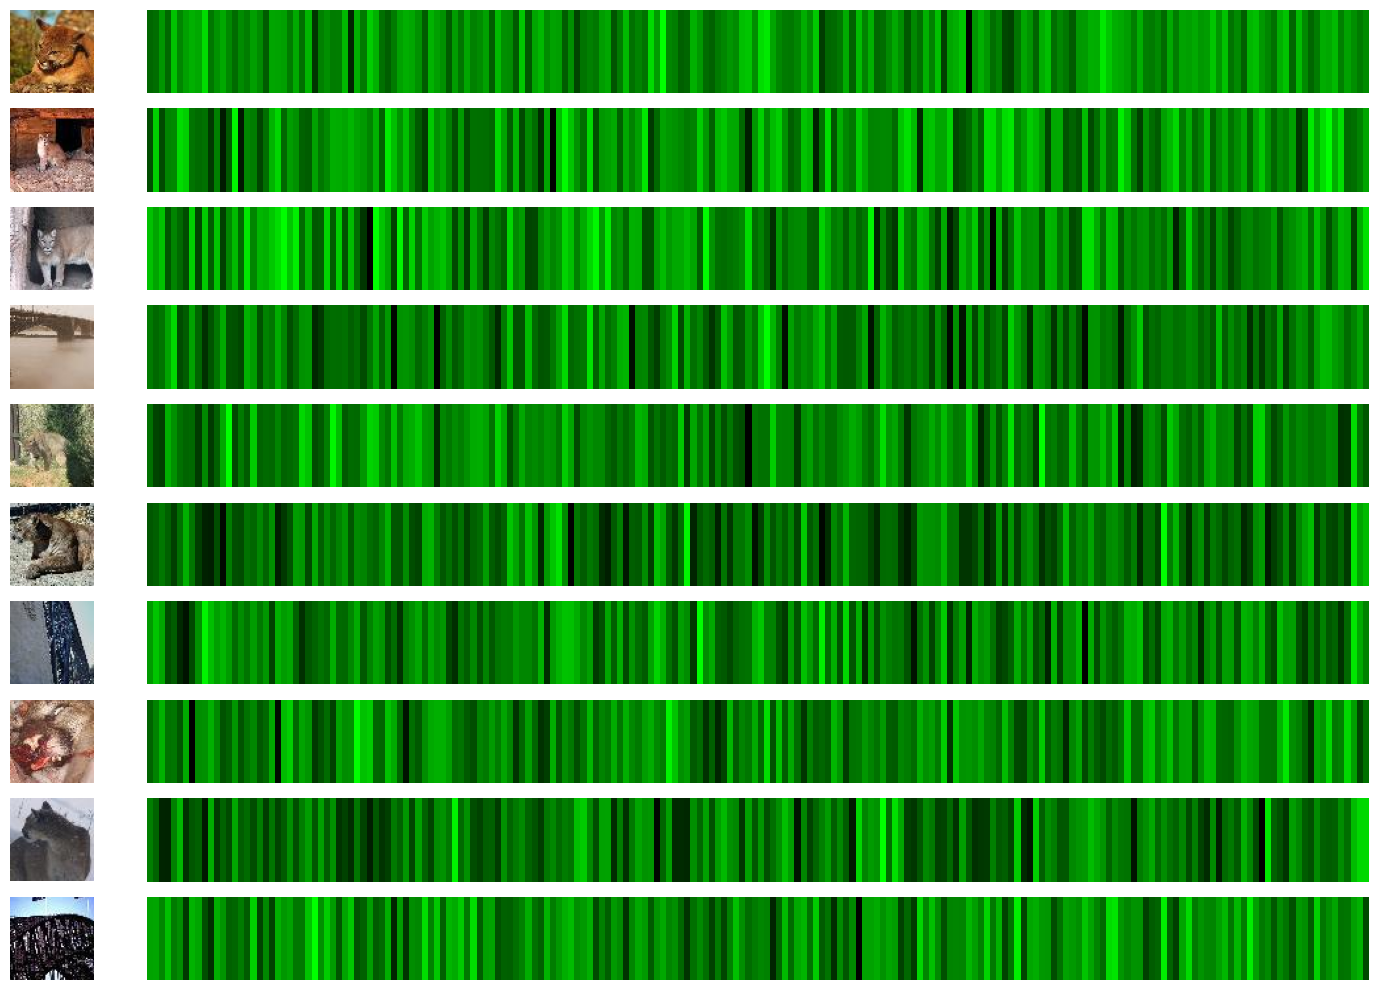

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Green CMAP
colors = [(0, 0, 0), (0, 1, 0)]  # Black to pure green
n_bins = 256  # Number of gradients
custom_green = LinearSegmentedColormap.from_list("custom_green", colors, N=n_bins)

# Number of random presentations to show
nPresentations = 10

# Randomly select indices from the range of unique stimuli (200)
random_indices = np.random.choice(200, size=nPresentations, replace=False)

# Create subplots
fig, axs = plt.subplots(nPresentations, 2, 
                        figsize=(15, nPresentations * 1),
                        gridspec_kw={'width_ratios': [1, 4]}) # Set the width of the plot

# Get the selected data and stimulus IDs
selected_data = benchmark_data.values[random_indices]
selected_stimulus_ids = benchmark_data['presentation']['stimulus_id'].values[random_indices]

for data, stimulus_id, ax_row in zip(selected_data, selected_stimulus_ids, axs):
    # Get and display the stimulus image
    stimulus_path = stimulus_set.get_stimulus(stimulus_id)
    print(stimulus_path)
    img = plt.imread(stimulus_path)
    # Left subplot: Image (1/5 width)
    ax_row[0].imshow(img)
    ax_row[0].axis('off')

    # Right subplot: Heatmap (4/5 width)
    sns.heatmap(data.reshape(1,-1), 
                cmap=custom_green, 
                ax=ax_row[1],
                cbar=False)
    
    # Remove ticks from heatmap
    ax_row[1].set_xticks([])
    ax_row[1].set_yticks([])

plt.tight_layout()
plt.show()